# Analisis exploratorio de datos del sistema público de alquiler de bicicletas de la ciudad de San Francisco entre 2013 y 2015.

En el siguiente análisis buscaremos responder a las siguientes preguntas:

- ¿Cómo afecta el clima los viajes en bicicleta?
- ¿En qué estaciones se alquilaron más y menos bicicletas?
- ¿Cuántos alquileres se utilizaron para viajar de una ciudad a otra?
- ¿Cómo evoluciona el uso del servicio con el tiempo?
- ¿Cómo satisface la demanda el servicio?
- ¿Cuánto tiempo están inactivas las bicicletas?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta, date
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [2]:
#Cargamos los datos
tripsDf = pd.read_csv("data/trip.csv")
stationsDf = pd.read_csv('data/station.csv')
weatherDf = pd.read_csv("data/weather.csv")

In [3]:
#Analizo los tipos de datos de trips
tripsDf.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [4]:
#Convierto datos de fechas a datetime
tripsDf['start_date'] = pd.to_datetime(tripsDf['start_date'], format = "%m/%d/%Y %H:%M")
tripsDf['end_date'] = pd.to_datetime(tripsDf['end_date'], format = "%m/%d/%Y %H:%M")

In [5]:
#Creo columna solo con datos de la fecha de inicio
tripsDf['date'] = tripsDf['start_date'].map(lambda x: x.date())

In [6]:
#Agrego columnas con el año, el mes y el dia
tripsDf['year'] = tripsDf['date'].map(lambda x: x.year)
tripsDf['month'] = tripsDf['date'].map(lambda x: x.month)
tripsDf['day'] = tripsDf['date'].map(lambda x: x.day)

In [7]:
#Agrego una columna con formato año-mes
tripsDf['year-month'] = tripsDf['start_date'].map(lambda x: x.strftime('%Y-%m'))

In [8]:
#Analizo los datos de stations
stationsDf.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [9]:
#Cambio el nombre de la columna id a station_id por claridad
stationsDf.rename(columns={'id':'station_id'}, inplace=True)

In [10]:
#Veamos los datos climaticos
weatherDf.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [11]:
#Pasamos a datetime el dato de la fecha
weatherDf.date = pd.to_datetime(weatherDf.date)

# ¿Cómo afecta el clima a los viajes en bicicleta?

In [12]:
#Obtenemos un dataframe con los viajes diarios por ciudad
weatherInfluenceDf = stationsDf[['station_id','city']]
weatherInfluenceDf.rename(columns={'station_id':'start_station_id'}, inplace=True)
weatherInfluenceDf = tripsDf.merge(weatherInfluenceDf)
weatherInfluenceDf = weatherInfluenceDf[['start_date','city']]
weatherInfluenceDf.start_date = weatherInfluenceDf.start_date.apply(lambda x: x.date())

#Creamos un dataframe que contenga el código postal de cada ciudad, en el orden de la
#columna city del dataframe weatherInfluenceDf
zip_code = []
for ciudad in weatherInfluenceDf.city:
    if (ciudad == 'San Francisco'):
        zip_code.append([94107])
    if (ciudad == 'Redwood City'):
        zip_code.append([94063])
    if (ciudad == 'Palo Alto'):
        zip_code.append([94301])
    if (ciudad == 'Mountain View'):
        zip_code.append([94041])
    if (ciudad == 'San Jose'):
        zip_code.append([95113])
        
zip_code_df = pd.DataFrame(zip_code, columns={'zip_code'})

#Retomando con el dataframe anterior con los viajes diarios por ciudad
weatherInfluenceDf = pd.concat([weatherInfluenceDf,zip_code_df], axis=1)
weatherInfluenceDf = weatherInfluenceDf[['start_date','zip_code']]
weatherInfluenceDf.insert(2,'total_trips',1)
weatherInfluenceDf = weatherInfluenceDf.groupby(['start_date','zip_code']).aggregate(sum).reset_index()
weatherInfluenceDf.start_date = pd.to_datetime(weatherInfluenceDf.start_date)
weatherInfluenceDf.rename(columns={'start_date' : 'date'}, inplace=True)

#Luego unificamos cada una de las cantidades halladas recién con el set de datos meteorológicos
weatherInfluenceDf = pd.merge(weatherDf[['date','mean_temperature_f','mean_wind_speed_mph','mean_visibility_miles','zip_code']],weatherInfluenceDf)
weatherInfluenceDf.head(5)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,date,mean_temperature_f,mean_wind_speed_mph,mean_visibility_miles,zip_code,total_trips
0,2013-08-29,68.0,11.0,10.0,94107,642
1,2013-08-30,69.0,13.0,10.0,94107,606
2,2013-08-31,64.0,15.0,10.0,94107,556
3,2013-09-01,66.0,13.0,10.0,94107,600
4,2013-09-02,69.0,12.0,10.0,94107,594


### ¿Cómo se relaciona la cantidad de viajes con la temperatura?

<IPython.core.display.Javascript object>


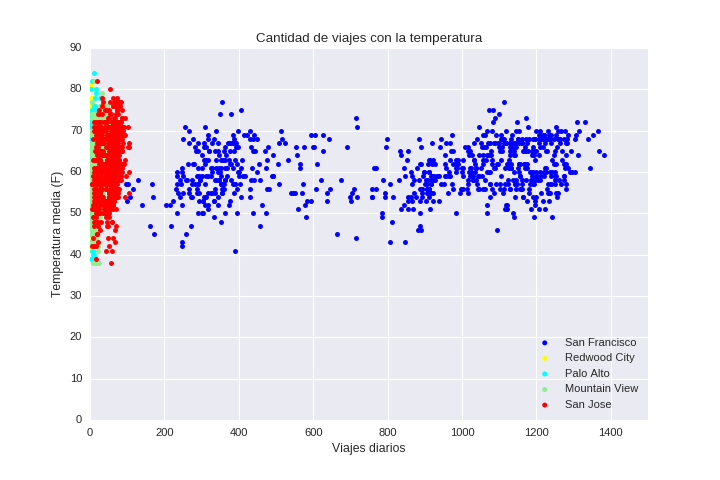

In [13]:
ax = weatherInfluenceDf[weatherInfluenceDf.zip_code == 94107].plot(kind='scatter', x='total_trips', y='mean_temperature_f', figsize=(9,6), color='blue', label='San Francisco', linewidth='0')

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94063].plot(kind='scatter', x='total_trips', y='mean_temperature_f', figsize=(9,6), color='yellow', label='Redwood City', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94301].plot(kind='scatter', x='total_trips', y='mean_temperature_f', figsize=(9,6), color='cyan', label='Palo Alto', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94041].plot(kind='scatter', x='total_trips', y='mean_temperature_f', figsize=(9,6), color='LightGreen', label='Mountain View',linewidth='0' ,ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 95113].plot(kind='scatter', x='total_trips', y='mean_temperature_f', figsize=(9,6), color='red', label='San Jose', linewidth='0',ax=ax)

ax.set_ylim(0,90)
ax.set_xlim(0,1500)
plt.legend(loc=4,prop={'size':10})
plt.xlabel('Viajes diarios')
plt.ylabel('Temperatura media (F)')
plt.title('Cantidad de viajes con la temperatura')

Analizamos la distribucion que se observa en el gráfico para los viajes de San Francisco, que presenta dos zonas bien definidas.

Veamos qué días de la semana corresponden a cada una.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


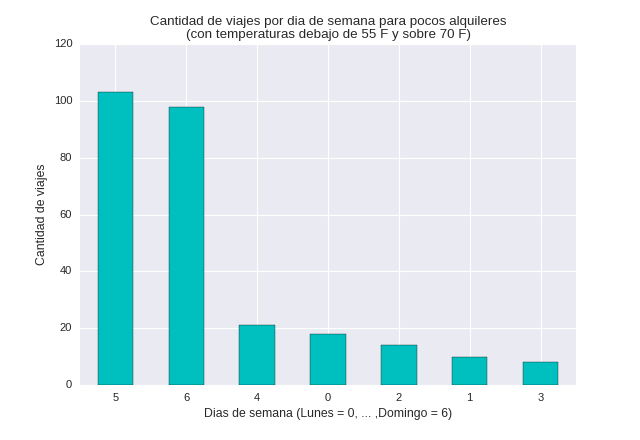

In [14]:
weatherInfluenceDf[weatherInfluenceDf.zip_code == 94107][weatherInfluenceDf['total_trips'] > 200][weatherInfluenceDf['total_trips'] < 800]\
['date'].apply(lambda x: x.dayofweek).\
value_counts().plot(kind='bar', color='c')

plt.xlabel('Dias de semana (Lunes = 0, ... ,Domingo = 6)')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de viajes')
plt.title('Cantidad de viajes por dia de semana para pocos alquileres\n(con temperaturas debajo de 55 F y sobre 70 F)')

La mayoría de los viajes para la mancha azul izquierda se producen los fin de semana.
Luego comprobamos qué sucede para la mancha azul derecha.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


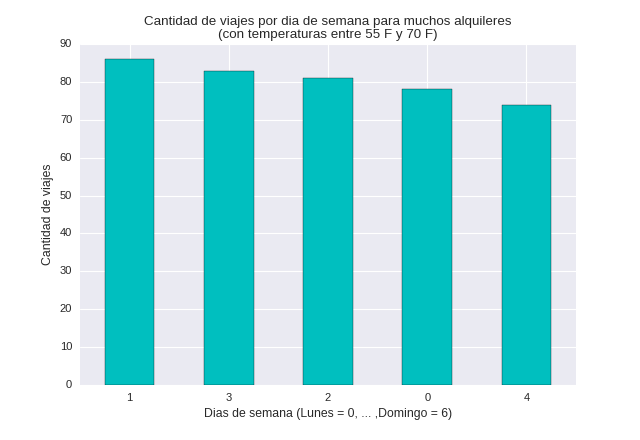

In [15]:
weatherInfluenceDf[weatherInfluenceDf.zip_code == 94107][weatherInfluenceDf['total_trips'] > 900][weatherInfluenceDf['total_trips'] < 1500]\
['date'].apply(lambda x: x.dayofweek).\
value_counts().plot(kind='bar', color='c')

plt.xlabel('Dias de semana (Lunes = 0, ... ,Domingo = 6)')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de viajes')
plt.title('Cantidad de viajes por dia de semana para muchos alquileres\n(con temperaturas entre 55 F y 70 F)')

Donde vemos que los viajes para muchos alquileres ocurren durante los días de semana, mientras que en los fin de semana prácticamente no hay viajes. 

Con esto pudimos corroborar que nuestra suposición respecto a las dos zonas azules es válida, lo que nos deja que:

En días de semana → Hay muchos viajes (mancha azul derecha)

En fin de semana → Hay pocos viajes (mancha azul izquierda)

### ¿Cómo afecta la velocidad del viento a la cantidad de viajes?

<IPython.core.display.Javascript object>


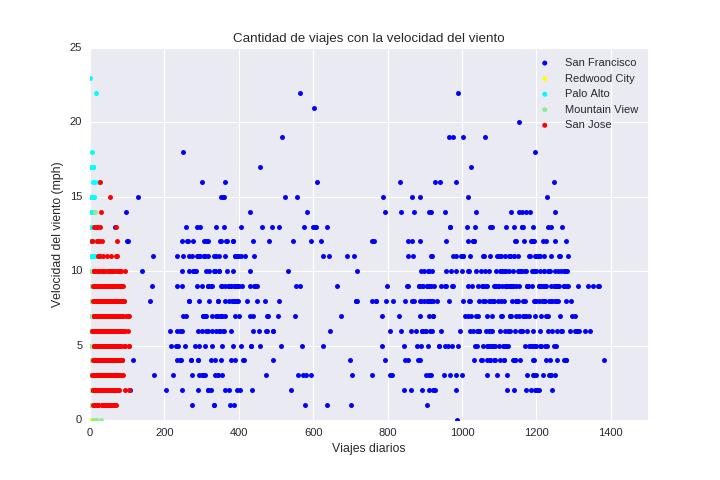

In [16]:
ax = weatherInfluenceDf[weatherInfluenceDf.zip_code == 94107].plot(kind='scatter', x='total_trips', y='mean_wind_speed_mph', figsize=(9,6), color='blue', label='San Francisco', linewidth='0')

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94063].plot(kind='scatter', x='total_trips', y='mean_wind_speed_mph', figsize=(9,6), color='yellow', label='Redwood City', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94301].plot(kind='scatter', x='total_trips', y='mean_wind_speed_mph', figsize=(9,6), color='cyan', label='Palo Alto', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94041].plot(kind='scatter', x='total_trips', y='mean_wind_speed_mph', figsize=(9,6), color='LightGreen', label='Mountain View',linewidth='0' ,ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 95113].plot(kind='scatter', x='total_trips', y='mean_wind_speed_mph', figsize=(9,6), color='red', label='San Jose', linewidth='0',ax=ax)

ax.set_ylim(0,25)
ax.set_xlim(0,1500)
plt.legend(loc=0,prop={'size':10})
plt.xlabel('Viajes diarios')
plt.ylabel('Velocidad del viento (mph)')
plt.title('Cantidad de viajes con la velocidad del viento')

### ¿Cómo afecta la visibilidad a la cantidad de viajes?

<IPython.core.display.Javascript object>


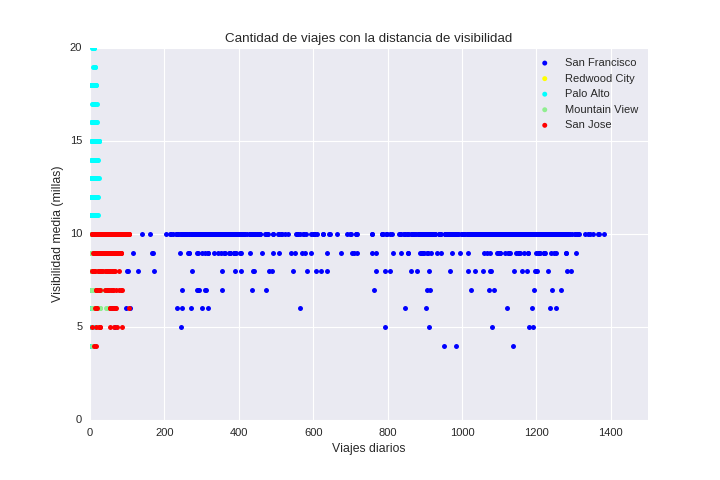

In [17]:
ax = weatherInfluenceDf[weatherInfluenceDf.zip_code == 94107].plot(kind='scatter', x='total_trips', y='mean_visibility_miles', figsize=(9,6), color='blue', label='San Francisco', linewidth='0')

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94063].plot(kind='scatter', x='total_trips', y='mean_visibility_miles', figsize=(9,6), color='yellow', label='Redwood City', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94301].plot(kind='scatter', x='total_trips', y='mean_visibility_miles', figsize=(9,6), color='cyan', label='Palo Alto', linewidth='0',ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 94041].plot(kind='scatter', x='total_trips', y='mean_visibility_miles', figsize=(9,6), color='LightGreen', label='Mountain View',linewidth='0' ,ax=ax)

weatherInfluenceDf[weatherInfluenceDf.zip_code == 95113].plot(kind='scatter', x='total_trips', y='mean_visibility_miles', figsize=(9,6), color='red', label='San Jose', linewidth='0',ax=ax)

ax.set_ylim(0,20)
ax.set_xlim(0,1500)
plt.legend(loc=0,prop={'size':10})
plt.xlabel('Viajes diarios')
plt.ylabel('Visibilidad media (millas)')
plt.title('Cantidad de viajes con la distancia de visibilidad')

Este gráfico nos dice que la gran mayoría de los viajes se efectúan en días donde la visibilidad es de 10 millas. Lo que llama la atención es que para más de 10 millas se aprecian pocos viajes, lo que se esperaba que los datos estén más distribuídos en zonas de mayor visibilidad. Mientras que, para distancias menores, es evidente que se distinguen menos viajes debido a que la niebla dificulta mucho viajar en bicicleta.
En base a esto, vamos a analizar por qué casi todos los viajes están en la distancia de 10 millas. Para ello, vamos a partir de un gráfico que muestra la cantidad de días totales para cada visibilidad.

<IPython.core.display.Javascript object>


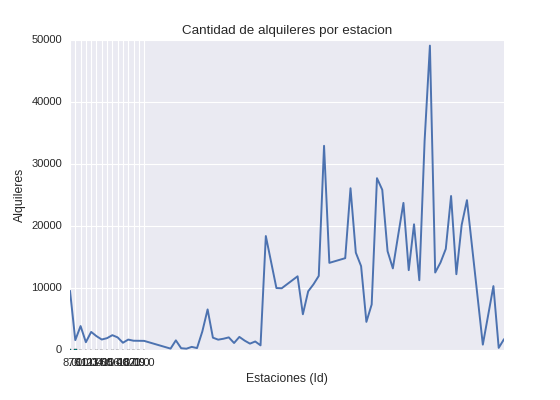

In [18]:
weatherInfluenceDf.mean_visibility_miles.value_counts().plot(kind='bar', color='c', figsize=(7,5))
plt.xlabel('Visibilidad promedio (millas)')
plt.ylabel('Cantidad de dias totales')
plt.title('Cantidad de dias para cada visibilidad')

De este gráfico obtenemos como conclusión que los viajes se concentran en días con visibilidad promedio de 10 millas, por el hecho de que es por amplio margen la condición más común.

# ¿En qué estaciones se alquilaron más y menos bicicletas?

In [19]:
tripsDf.groupby('start_station_id').size().plot(figsize=(7,5))
plt.xlabel('Estaciones (Id)')
plt.ylabel('Alquileres')
plt.title('Cantidad de alquileres por estacion')

Como podemos ver, las estaciones de 40 a 80 son las que reciben más alquileres respeto al resto de las estaciones, así que a partir de esto vamos a profundizar el análisis de por qué dichas estaciones reciben una cantidad de alquileres considerable respecto a las demás estaciones. Para ello realizamos el siguiente gráfico que contiene la cantidad de alquileres por estación y también por ciudad:

In [20]:
#Creamos el dataframe para realizar el grafico
tripsPerStationDf = tripsDf.groupby('start_station_id', as_index=False).size()
tripsPerStationDf.name = 'count'
tripsPerStationDf = tripsPerStationDf.reset_index()
tripsPerStationDf.rename(columns={'start_station_id':'station_id'}, inplace=True)
tripsPerStationDf = stationsDf.loc[:, ['station_id', 'name', 'city']].merge(tripsPerStationDf)
tripsPerStationDf.head(5)

,station_id,name,city,count
0,2,San Jose Diridon Caltrain Station,San Jose,9558
1,3,San Jose Civic Center,San Jose,1594
2,4,Santa Clara at Almaden,San Jose,3861
3,5,Adobe on Almaden,San Jose,1257
4,6,San Pedro Square,San Jose,2917


<IPython.core.display.Javascript object>


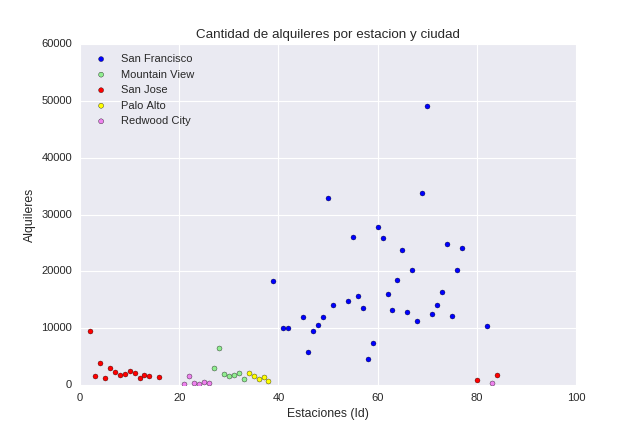

In [21]:
ax = tripsPerStationDf[tripsPerStationDf.city == 'San Francisco'].\
plot(kind='scatter', x='station_id', y='count', color='blue', label='San Francisco')

tripsPerStationDf[tripsPerStationDf.city == 'Mountain View'].\
plot(kind='scatter', x='station_id', y='count', color='LightGreen', label='Mountain View', ax=ax)

tripsPerStationDf[tripsPerStationDf.city == 'San Jose'].\
plot(kind='scatter', x='station_id', y='count', color='red', label='San Jose', ax=ax)

tripsPerStationDf[tripsPerStationDf.city == 'Palo Alto'].\
plot(kind='scatter', x='station_id', y='count', color='yellow', label='Palo Alto', ax=ax)

tripsPerStationDf[tripsPerStationDf.city == 'Redwood City'].\
plot(kind='scatter', x='station_id', y='count', color='violet', label='Redwood City', ax=ax)

ax.set_ylim(0,60000)
ax.set_xlim(0,100)
ax.legend(loc=2)
ax.set_xlabel('Estaciones (Id)')
ax.set_ylabel('Alquileres')
ax.set_title('Cantidad de alquileres por estacion y ciudad')

Donde podemos ver claramente, que las estaciones entre 40 y 80 se encuentran ubicadas en la ciudad de San Francisco, siendo la ciudad más grande y poblada de las 5 ciudades que hay en el set de dato. Por ese motivo, se considera que los alquileres que hay en dichas estaciones son mucho más frecuentes que las estaciones que se encuentran en las otras ciudades. Además lo que difiere mucho en la cantidad de alquileres es que de todas las estaciones, la gran mayoría se encuentran en San Francisco, mientras que el resto de las ciudades tienen muy pocas estaciones y debido a eso los alquileres son menos frecuentes.

A partir de este gráfico, en el ámbito de las estaciones de San Francisco, llama la atención el punto azul ubicado muy arriba que corresponde a la estación 70, que inclusive en el primer gráfico de este análisis se puede apreciar un pico en dicha estación con una cantidad de alquileres considerablemente mayor a los demás, por lo que a partir de esta duda se hará un análisis.

In [22]:
tripsPerStationDf[tripsPerStationDf.city == 'San Francisco'].sort(['count'], ascending=False).head(1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,station_id,name,city,count
58,70,San Francisco Caltrain (Townsend at 4th),San Francisco,49092


Buscando en internet el mapa de San Francisco, vimos que dicha estación se encuentra al lado de una terminal de trenes, por lo que se podría pensar que mucha gente que viaja en tren realiza combinación con dicha estación de bicicletas.
Vamos a comprobar en qué estaciones terminaron las bicicletas que partieron de la estación San Francisco Caltrain (Townsend at 4th), para corroborar si se encuentran dentro de la ciudad (en San Francisco) y no en otras ciudades. En caso afirmativo, se podría decir que mucha gente usa el tren para viajar a San Francisco desde otra ciudad, y luego usa las bicicletas para viajar de un punto a otro dentro de la misma ciudad (San Francisco).

In [23]:
endingStationsDf = tripsDf[tripsDf.start_station_id == 70][['end_station_id']]
endingStationsDf = endingStationsDf.rename(columns={'end_station_id' : 'station_id'})
endingStationsDf = endingStationsDf.merge(stationsDf[['station_id','city']])
endingStationsDf.insert(2,'count',1)
endingStationsDf = endingStationsDf.groupby(['station_id','city']).aggregate(sum)
endingStationsDf = endingStationsDf.reset_index()
endingStationsDf.head(5)

,station_id,city,count
0,2,San Jose,1
1,29,Mountain View,1
2,39,San Francisco,1406
3,41,San Francisco,1294
4,42,San Francisco,1700


In [24]:
endingStationsDf.city.value_counts()

San Francisco    35
San Jose          1
Mountain View     1
Name: city, dtype: int64

<IPython.core.display.Javascript object>


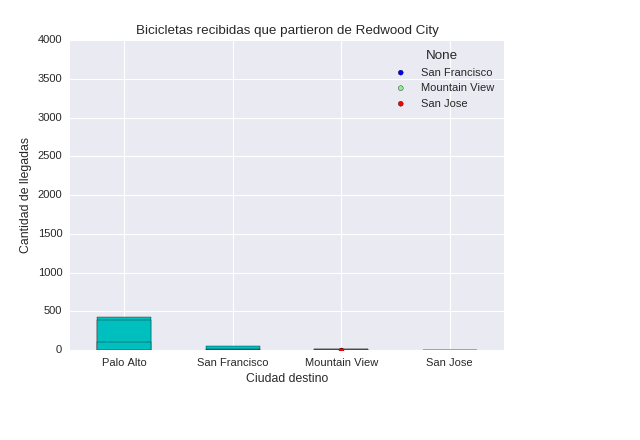

In [25]:
ax = endingStationsDf[endingStationsDf.city == 'San Francisco'].\
plot(kind='scatter', x='station_id', y='count', color='blue', label='San Francisco', linewidth='0')

endingStationsDf[endingStationsDf.city == 'Mountain View'].\
plot(kind='scatter', x='station_id', y='count', color='LightGreen', label='Mountain View', linewidth='0', ax=ax)

endingStationsDf[endingStationsDf.city == 'San Jose'].\
plot(kind='scatter', x='station_id', y='count', color='red', label='San Jose', linewidth='0', ax=ax)

ax.set_ylim(0,4000)
ax.set_xlim(0,100)
ax.legend(loc=2)
ax.set_xlabel('Estaciones (Id)')
ax.set_ylabel('Bicicletas recibidas')
ax.set_title('Cantidad de bicicletas recibidas por estacion y ciudad\n(partidas desde la estacion 70)')

Como vemos, la mayoría de los que alquilan en la estación 70 van a terminar en estaciones dentro de la ciudad de San Francisco, por lo tanto nuestra deducción puede ser válida. Sin embargo, llama la atención que hay un par de alquileres que fueron a parar en estaciones de otras ciudades, como vemos, un alquiler fue a parar en una estación de Mountain View, y la otra en San Jose. En base a eso hagamos un análisis sobre dichos viajes, en un principio se podría asumir que esos viajes se efectuaron en un horario donde la estación de trenes está cerrado, como en la madrugada.

In [26]:
combinationDf = stationsDf[['station_id','city']].rename(columns={'station_id' : 'end_station_id'})
combinationDf = tripsDf.merge(combinationDf[['end_station_id','city']])
combinationDf = combinationDf.rename(columns={'city' : 'destination_city'})
combinationDf[['start_date','start_station_name','start_station_id','end_date','end_station_name','end_station_id','destination_city']][(combinationDf.start_station_id == 70) & (combinationDf.destination_city != 'San Francisco')]

,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,destination_city
586420,2013-09-06 11:35:00,San Francisco Caltrain (Townsend at 4th),70,2013-09-06 16:29:00,San Jose Diridon Caltrain Station,2,San Jose
650447,2014-09-01 13:40:00,San Francisco Caltrain (Townsend at 4th),70,2014-09-01 21:31:00,San Antonio Caltrain Station,29,Mountain View


Los datos no coinciden con nuestra suposición.

# ¿Cuántos alquileres se utilizaron para viajar de una ciudad a otra?

In [27]:
stations_c = stationsDf[['station_id','city']]
stations_c = stations_c.rename(columns={'station_id' : 'start_station_id', 'city' : 'start_city'})
tripsToOtherCityDf = tripsDf.merge(stations_c[['start_station_id','start_city']])
stations_c = stations_c.rename(columns={'start_station_id' : 'end_station_id', 'start_city' : 'end_city'})
tripsToOtherCityDf = tripsToOtherCityDf.merge(stations_c[['end_station_id','end_city']])
tripsToOtherCityDf.head(1)


,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date,year,month,day,year-month,start_city,end_city
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29,2013,8,29,2013-08,San Francisco,San Francisco


Armamos un nuevo DataFrame donde en cada ciudad colocamos los alquileres cuyo destino fueron en la misma ciudad del que partió, y los alquieres cuyo destino fueron en otra ciudad del que partió.

In [28]:
entregas = []
for i in range(0,len(stationsDf.city.value_counts())):
    entregas.append([stationsDf.city.value_counts().index[i],\
                     tripsToOtherCityDf[tripsToOtherCityDf.start_city == stationsDf.city.value_counts().index[i]][(tripsToOtherCityDf.start_city) == (tripsToOtherCityDf.end_city)].shape[0],\
                     tripsToOtherCityDf[tripsToOtherCityDf.start_city == stationsDf.city.value_counts().index[i]][(tripsToOtherCityDf.start_city) != (tripsToOtherCityDf.end_city)].shape[0]
                    ])
entregasDf = pd.DataFrame(entregas, columns=['city','same_city_destination','other_city_destination'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [29]:
entregasDf

,city,same_city_destination,other_city_destination
0,San Francisco,603693,15
1,San Jose,37856,22
2,Redwood City,3329,104
3,Mountain View,17746,421
4,Palo Alto,6293,480


Como vemos en la tabla, en cada ciudad se puede concluir que la mayoría de los viajes son efectuados sobre la misma ciudad o alrededores, por lo que las bicicletas son devueltas en estaciones de la misma ciudad al que partió.
En cuanto al viaje hacia otras ciudades vamos a realizar algunos análisis. Como vemos, tanto en Mountain View como en Palo Alto, hay una cantidad considerable de alquileres que van desde alguna de ambas ciudades a otra ciudad. Usando esta base, vamos a ver cuál es la ciudad destino con mayor cantidad de llegadas.

In [30]:
tripsToOtherCityDf[tripsToOtherCityDf.start_city == 'Palo Alto'][(tripsToOtherCityDf.start_city) != (tripsToOtherCityDf.end_city)].end_city.value_counts().plot(kind='bar', figsize=(7,5), color='c')
plt.xlabel('Ciudad destino')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de llegadas')
plt.title('Bicicletas recibidas que partieron de Palo Alto')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Vemos que muchos de los que salen de Palo Alto, viajan en bicicleta hasta Mountain View, que es la ciudad más cercana a Palo Alto (unos 10 Km). Mientras que otra pequeña porción va a Redwood City, que queda un poco más lejos (unos 14 Km). Y unos muy pocos a San Francisco que queda mucho más lejos (55 km).

In [31]:
tripsToOtherCityDf[tripsToOtherCityDf.start_city == 'Mountain View'][(tripsToOtherCityDf.start_city) != (tripsToOtherCityDf.end_city)].end_city.value_counts().plot(kind='bar', figsize=(7, 5), color='c')
plt.xlabel('Ciudad destino')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de llegadas')
plt.title('Bicicletas recibidas que partieron de Mountain View')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Y para Mountain View pasa al revés, la gran mayoría viaja para Palo Alto. Acá llama la atención que haya más viajes hacia San Jose (21 km) y a San Francisco (61 km) que se encuentran más lejos que Redwood City (17 km), que tiene menos viajes.
Por último también vamos a analizar las bicicletas que partieron de Redwood City para ver qué datos obtenemos, más allá de que su cantidad de destinos hacia otras ciudades sea mucho menor que Palo Alto y Mountain View, aunque considerablemente mayor a San Francisco y San José que son muy pocos.

In [32]:
tripsToOtherCityDf[tripsToOtherCityDf.start_city == 'Redwood City'][(tripsToOtherCityDf.start_city) != (tripsToOtherCityDf.end_city)].end_city.value_counts().plot(kind='bar', figsize=(7, 5), color='c')
plt.xlabel('Ciudad destino')
plt.xticks(rotation=0)
plt.ylabel('Cantidad de llegadas')
plt.title('Bicicletas recibidas que partieron de Redwood City')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Y acá vemos que la gran mayoría va hacia Palo Alto.
En cuanto a las bicicletas que parten de San Francisco y San Jose son muy pocas de las que viajan a otras ciudades, por lo que no consideramos que sea necesario analizar a qué ciudades van a parar.
De esto sacamos la conclusión de que la gran mayoría de alquileres que se usaron para viajar en bicicleta de una ciudad a otra, se dió con mucha intensidad entre Palo Alto y Mountain View, cuya distancia entre ambas ciudades son 10 Km. Por otro lado se dió entre Palo Alto y Redwood City, aunque con menos intensidad que el anterior, cuya distancia entre ambas ciudades son 14 Km.

# ¿Cómo evoluciona con el tiempo la cantidad de viajes?

Se realizará un análisis de la cantidad de viajes utilizando los datos de los mismos entre Agosto del 2013 y Agosto del 2015, con el fin de determinar cómo se comporta la demanda del servicio en el tiempo.

### ¿Qué días hubo más viajes?

In [33]:
#Viajes por fecha
tripsPerDay = pd.DataFrame({'count' : tripsDf.groupby(['date']).size()}).reset_index()
tripsPerDay['Dia'] = tripsPerDay['date'].map(lambda x: x.strftime('%A'))

In [34]:
#Top 5 de días con más viajes
tripsPerDay.sort_values(by='count', ascending=False).head(10).reset_index()

,index,date,count,Dia
0,382,2014-09-15,1516,Monday
1,362,2014-08-26,1513,Tuesday
2,426,2014-10-29,1496,Wednesday
3,411,2014-10-14,1496,Tuesday
4,363,2014-08-27,1479,Wednesday
5,727,2015-08-26,1465,Wednesday
6,413,2014-10-16,1462,Thursday
7,399,2014-10-02,1452,Thursday
8,698,2015-07-28,1451,Tuesday
9,728,2015-08-27,1443,Thursday


No sólo observamos que los días con mayor cantidad de viajes son laborables, sino que recién en la posición 6 aparece un día correspondiente al último año del cual se tienen datos. 

Podría indicar que no han aumentado considerablemente los viajes, aunque también se observa que los meses del 2014 con mayor cantidad de viajes son posteriores a Agosto en su mayoría, meses de los que no tenemos datos para el año 2015.

### Cantidad de viajes, mes a mes

<IPython.core.display.Javascript object>


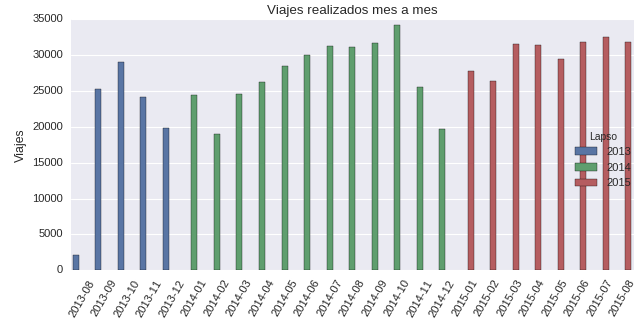

In [35]:
#Plot de viajes por mes
monthlyTrips = tripsDf
monthlyTrips = pd.DataFrame({'count' : tripsDf.groupby(['year', 'month', 'year-month']).size()}).reset_index()
monthlyTrips = monthlyTrips.loc[:, ['count', 'year-month', 'year', 'month']]
monthlyTrips.rename(columns={'count':'Viajes', 'month':'Mes', 'year':'Lapso', 'year-month':'Fecha'}, inplace=True)

g = sns.factorplot(x='Fecha', y='Viajes', hue='Lapso', data=monthlyTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

De nuevo, vemos que el pico de viajes ocurrió durante el 2014, en el mes de Octubre. 

### Comparación interanual de viajes mensuales

Para una comparación que no esté atada a las condiciones particulares de cada mes, vamos a analizar de forma interanual la cantidad mensual de viajes.

<IPython.core.display.Javascript object>


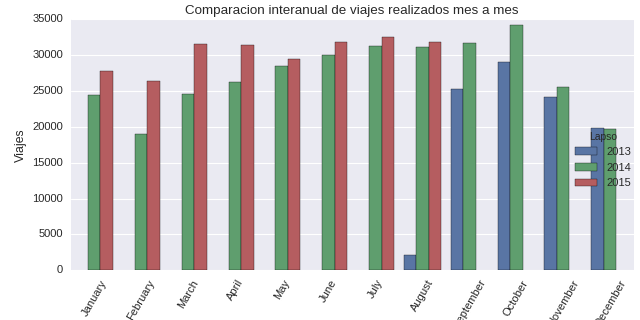

In [36]:
#Plot de viajes por mes
monthlyTrips = tripsDf
monthlyTrips = pd.DataFrame({'count' : tripsDf.groupby(['year', 'month','date']).size()}).reset_index()
monthlyTrips['month_name'] = monthlyTrips['date'].map(lambda x: x.strftime('%B'))
monthlyTrips = monthlyTrips.groupby(['month', 'year', 'month_name']).sum()
monthlyTrips = monthlyTrips.reset_index()

monthlyTrips.rename(columns={'count':'Viajes', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)

g = sns.factorplot(x='Mes', y='Viajes', hue='Lapso', data=monthlyTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

Con este análisis observamos que en todos los meses de los que se tienen datos, mientras más próximo es el año más cantidad de viajes se realizaron. 

Con esto, concluimos que si bien el pico de viajes mensuales fue en Octubre de 2014, de confirmarse la tendencia que encontramos deberían producirse más viajes en Octubre de 2015.

### Viajes por año

Veamos qué pasa anualmente. Graficamos la cantidad de viajes acumulados:

<IPython.core.display.Javascript object>


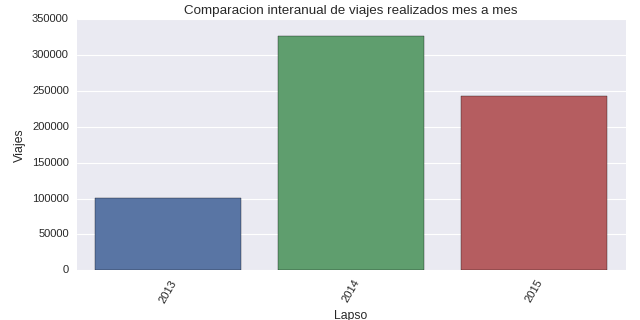

In [37]:
#Viajes por año
yearTrips = tripsDf
yearTrips = pd.DataFrame({'count' : tripsDf.groupby(['year']).size()}).reset_index()
yearTrips.rename(columns={'count':'Viajes', 'year':'Lapso'}, inplace=True)

g = sns.factorplot(x='Lapso', y='Viajes', data=yearTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de viajes realizados mes a mes')
g.set_xticklabels(rotation=60)

De nuevo, dado set de datos con el que contamos tampoco podemos concluir demasiado, ya que no tenemos datos de todo 2013 ni de todo 2015.

### Viajes promedio por año

Para poder sacar alguna conclusión, veamos el promedio de viajes por año. 

In [38]:
#Viajes promedio por año
yearAverageTrips = pd.DataFrame({'count' : tripsDf.groupby(['year']).size(),\
                             'days' : tripsDf.groupby(['year']).date.nunique(),\
                             'average_trips' : tripsDf.groupby(['year']).size()/tripsDf.groupby(['year']).date.nunique()}).reset_index()

yearAverageTrips.rename(columns={'year':'Lapso', 'average_trips':'Viajes promedio'}, inplace=True)

yearAverageTrips

,Lapso,Viajes promedio,count,days
0,2013,804.504000,100563,125
1,2014,894.079452,326339,365
2,2015,1000.234568,243057,243


Aumento de 2013 a 2014:

In [39]:
((894.079452 - 804.504000)*100/804.504000)

11.134245696727415

Aumento de 2014 a 2015:

In [40]:
((1000.234568 - 894.079452)*100/894.079452)

11.873118855660719

<IPython.core.display.Javascript object>


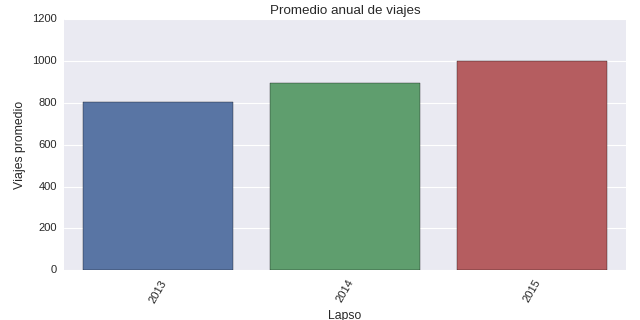

In [41]:
g = sns.factorplot(x='Lapso', y='Viajes promedio', data=yearAverageTrips, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Promedio anual de viajes')
g.set_xticklabels(rotation=60)

Con este gráfico podemos concluir que año a año, en promedio, aumenta la cantidad de viajes en torno al 11%.

# ¿Cómo se satisface la demanda del servicio?

Vimos que la demanda del servicio tiende a aumentar con el tiempo. Ahora, veamos cómo afecta este aumento en la calidad del mismo.

Se analizará utilizando los datos minuto a minuto de las estaciones, en cuántas oportunidades se encontraban sin bicicletas disponibles.

In [42]:
#Obtenemos los datos en los que alguna estación se quedó sin bicicletas
df = []
for chunk in pd.read_csv('data/status.csv', chunksize=1000000):
    df.append(chunk[chunk.bikes_available == 0])
emptyStationDf = pd.concat(df)

In [43]:
len(emptyStationDf)

529004

In [44]:
emptyStationDf.dtypes

station_id          int64
bikes_available     int64
docks_available     int64
time               object
dtype: object

In [45]:
#Convierto a fecha el dato de time
emptyStationDf['time'] = pd.to_datetime(emptyStationDf['time'], format = "%Y/%m/%d %H:%M:%S")

#Agrego columnas para el año, mes, día y hora
emptyStationDf['year'] = emptyStationDf['time'].map(lambda x: x.year)
emptyStationDf['month'] = emptyStationDf['time'].map(lambda x: x.month)
emptyStationDf['day'] = emptyStationDf['time'].map(lambda x: x.day)
emptyStationDf['hour'] = emptyStationDf['time'].map(lambda x: x.hour)

In [46]:
#Combino datos de estaciones vacías con los datos de las estaciones
emptyStationDf = emptyStationDf.merge(stationsDf, on='station_id')

In [47]:
emptyStationDf.head(1)

,station_id,bikes_available,docks_available,time,year,month,day,hour,name,lat,long,dock_count,city,installation_date
0,2,0,27,2013-11-03 02:00:01,2013,11,3,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013


### ¿Qué estaciones informaron más veces que no tenían bicicletas?

In [48]:
moreTimesEmpty = emptyStationDf.groupby("name", as_index=False).size()
moreTimesEmpty.name = 'count'
moreTimesEmpty = moreTimesEmpty.reset_index()

#Estaciones más veces vacías
moreTimesEmpty = moreTimesEmpty.merge(stationsDf, on='name')
moreTimesEmpty = moreTimesEmpty.loc[:, ['station_id', 'name', 'city', 'count', 'dock_count']].sort_values(by='count', ascending=False)
moreTimesEmpty.head(10).reset_index()

,index,station_id,name,city,count,dock_count
0,12,45,Commercial at Montgomery,San Francisco,29198,15
1,28,76,Market at 4th,San Francisco,24725,19
2,18,48,Embarcadero at Vallejo,San Francisco,24401,15
3,0,62,2nd at Folsom,San Francisco,24077,19
4,17,60,Embarcadero at Sansome,San Francisco,23143,15
5,49,70,San Francisco Caltrain (Townsend at 4th),San Francisco,21726,19
6,22,73,Grant Avenue at Columbus Avenue,San Francisco,20739,15
7,11,41,Clay at Battery,San Francisco,19080,15
8,7,82,Broadway St at Battery St,San Francisco,17824,15
9,1,64,2nd at South Park,San Francisco,17111,15


Observamos que las primeras 10 estaciones con mayor cantidad de registros sin bicicletas disponibles se encuentran en San Francisco. Esto tiene sentido teniendo en cuenta el análisis previo, que concluyó que la mayor cantidad de alquileres se da en dicha ciudad.

### ¿En qué horarios se da mayormente que no haya bicicletas?

In [49]:
hoursEmpty = emptyStationDf.groupby("hour", as_index=False).size()
hoursEmpty.name = 'count'
hoursEmpty = hoursEmpty.reset_index()

#Estaciones más veces vacías
hoursEmpty = hoursEmpty.loc[:, ['hour', 'count']].sort_values(by='count', ascending=False)
hoursEmpty.head(10)

,hour,count
18,18,63200
9,9,50322
17,17,44140
10,10,34089
8,8,33174
19,19,29980
7,7,26784
6,6,22234
16,16,20285
11,11,19973


In [50]:
#Grafico de los datos de registros por hora
hoursEmpty.rename(columns={'hour':'Hora', 'count':'Registros'}, inplace=True)
g = sns.factorplot(x='Hora', y='Registros', data=hoursEmpty, kind = 'bar', size=4, aspect = 2, color='blue')
g.axes.flat[0].set_title('Registros de estacion sin bicicletas segun horarios del dia')

<IPython.core.display.Javascript object>

Como era de esperarse, en las horas en que se utilizan las bicicletas para movilizarse a distintos puntos de trabajo, escuelas y demás, es cuando mayor cantidad de registros de estaciones sin bicicletas se acumulan.

### ¿Qué días se dieron la mayor cantidad de informes de estaciones sin bicicletas?

In [51]:
emptyPerDay = emptyStationDf.groupby(['year', 'month', 'day', 'station_id', 'name', 'city', 'docks_available']).size()
emptyPerDay.name = 'count'
emptyPerDay = emptyPerDay.reset_index()
emptyPerDay['date'] = emptyPerDay.apply(lambda x: date(x.year, x.month, x.day), axis=1)
emptyPerDay['day_name'] = emptyPerDay['date'].apply(lambda x: x.strftime('%A'))
emptyPerDay.sort_values(by='count', ascending=False, inplace=True)
emptyPerDay.head(10).reset_index()

,index,year,month,day,station_id,name,city,docks_available,count,date,day_name
0,4901,2014,11,10,10,San Jose City Hall,San Jose,15,1044,2014-11-10,Monday
1,5526,2015,1,16,34,Palo Alto Caltrain Station,Palo Alto,23,964,2015-01-16,Friday
2,7625,2015,5,28,32,Castro Street and El Camino Real,Mountain View,11,850,2015-05-28,Thursday
3,3848,2014,8,29,35,University and Emerson,Palo Alto,11,707,2014-08-29,Friday
4,6339,2015,3,11,4,Santa Clara at Almaden,San Jose,11,651,2015-03-11,Wednesday
5,5510,2015,1,15,49,Spear at Folsom,San Francisco,19,607,2015-01-15,Thursday
6,4523,2014,10,14,63,Howard at 2nd,San Francisco,19,598,2014-10-14,Tuesday
7,6692,2015,3,31,32,Castro Street and El Camino Real,Mountain View,11,594,2015-03-31,Tuesday
8,3426,2014,7,29,64,2nd at South Park,San Francisco,15,578,2014-07-29,Tuesday
9,7672,2015,5,30,84,Ryland Park,San Jose,15,570,2015-05-30,Saturday


Observamos como se mantiene la tendencia de que los días de semana tienen la mayor demanda. Recién en la décima posición aparece un día del fin de semana en el ránking de registros de estación sin bicicletas.

### ¿Cómo evolucionó la cantidad de informes de estaciones sin bicicletas en el tiempo?

Podemos analizar estación por estación cómo fue aumetanto la cantidad de registros en los que no tenían bicicletas disponibles.

In [52]:
#Defino una función para probar con distintas estaciones fácilmente
def plotEmptyStationEvents(stationId):
    name = emptyStationDf[emptyStationDf['station_id'] == stationToPlot].head(1)['name'].values[0]
    monthlyFrec = emptyStationDf[emptyStationDf['station_id'] == stationId].groupby(['month', 'year']).size()
    monthlyFrec.name = 'count'
    monthlyFrec = monthlyFrec.reset_index()
    monthlyFrec['date'] = monthlyFrec.apply(lambda x : date(x['year'], x['month'], 1), axis=1)
    monthlyFrec['year-month'] = monthlyFrec['date'].map(lambda x: x.strftime('%Y-%m'))
    monthlyFrec['month_name'] = monthlyFrec['date'].map(lambda x: x.strftime('%B'))
    monthlyFrec.set_index(monthlyFrec['date'], inplace=True)
    monthlyFrec = monthlyFrec.loc[:, ['count', 'year-month', 'year', 'month', 'month_name']]
    monthlyFrec.rename(columns={'count':'Registros', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)
    monthlyFrec.reset_index(inplace=True)
    g = sns.factorplot(x='Mes', y='Registros', hue='Lapso', data=monthlyFrec, kind = 'bar', size=4, aspect = 2)
    g.axes.flat[0].set_title('Comparacion interanual de registros en los que la estacion ' + stationName + ' no tenia bicicletas disponibles')
    g.set_xticklabels(rotation=60)

Analizamos dos casos:
- La estación que presentó mayor cantidad de registros: Commercial at Montgomery (45).
- La estación en la que se dio el día con mayor cantidad de registros: San Jose City Hall (10).

In [54]:
#Pruebo Commercial at Montgomery
stationToPlot = 45
plotEmptyStationEvents(stationToPlot)

<IPython.core.display.Javascript object>

NameError: global name 'stationName' is not defined

En este caso, se observa una tendencia clara de aumento de registros sin bicicleta, mes a mes, desde Septiembre hasta Marzo, pero que desde Abril hasta Agosto se revierte.

In [55]:
#Pruebo San Jose City Hall
stationToPlot = 10
plotEmptyStationEvents(stationToPlot)

<IPython.core.display.Javascript object>

NameError: global name 'stationName' is not defined

Para San Jose City Hall, vemos que durante 2014 se registraron considerablemente estados en los que no tenía bicicletas dispinibles, pero que tanto en 2013 como en 2015, no se aprecia una cantidad de la misma magnitud.

Vimos que para dos casos particulares, la tendencia no es del todo clara. Veamos cómo es la situación en general.

In [56]:
#Comparación mes a mes
monthlyFrec = emptyStationDf.groupby(['month', 'year']).size()
monthlyFrec.name = 'count'
monthlyFrec = monthlyFrec.reset_index()
monthlyFrec.head(2)

,month,year,count
0,1,2014,14249
1,1,2015,20789


<IPython.core.display.Javascript object>


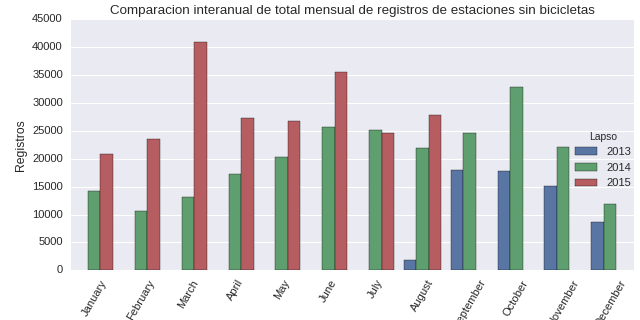

In [57]:
monthlyFrec['date'] = monthlyFrec.apply(lambda x : date(x.year, x.month, 1), axis=1)
monthlyFrec['year-month'] = monthlyFrec['date'].map(lambda x: x.strftime('%Y-%m'))
monthlyFrec['month_name'] = monthlyFrec['date'].map(lambda x: x.strftime('%B'))
monthlyFrec.set_index(monthlyFrec['date'], inplace=True)
monthlyFrec = monthlyFrec.loc[:, ['count', 'year-month', 'year', 'month_name']]
monthlyFrec.rename(columns={'count':'Registros', 'month_name':'Mes', 'year':'Lapso'}, inplace=True)
monthlyFrec.reset_index(inplace=True)

g = sns.factorplot(x='Mes', y='Registros', hue='Lapso', data=monthlyFrec, kind = 'bar', size=4, aspect = 2)
g.axes.flat[0].set_title('Comparacion interanual de total mensual de registros de estaciones sin bicicletas')
g.set_xticklabels(rotation=60)

Analizando todas las estaciones en conjunto, se ve una clara tendencia a la alza de la cantidad de registros en los que las estaciones se quedan sin bicicletas.

Cómo conclusión, observamos que la ciudad cuyas estaciones se quedan sin bicicletas con más frecuencia es San Francisco, que los horarios en los que más sucede es durante la mañana (pico a las 9hs) y durante la tarde (pico a las 18hs), y que en general, mes a mes aumenta la cantidad de registros de esta índole. 

# ¿Cuánto tiempo están inactivas las bicicletas?

Se analizará el uso cada bicicleta.

### ¿Cuántas bicicletas hay en el set de datos?

In [58]:
len(tripsDf.groupby('bike_id').size())

700

### ¿Cómo son los intervalos de inactividad de las bicicletas?

Análisis de inactividad hasta de estreno, y desde último uso hasta la última fecha registrada en el set de datos.

In [59]:
# Creo un set de datos con el primer y último viaje de cada bicicleta
bikes = tripsDf.groupby('bike_id').agg(['count']).reset_index().loc[:,['bike_id']]
firstLastByBike = []
for index, row in bikes.iterrows():
    bikeId = row['bike_id'].values[0]
    tripsPerBike = tripsDf[tripsDf['bike_id'] == bikeId]
    tripsPerBike = tripsPerBike.sort_values(by='start_date')
    firstTrip = tripsPerBike.iloc[0]['start_date']
    lastTrip = tripsPerBike.iloc[len(tripsPerBike)-1]['start_date']
    firstLastByBike.append([bikeId, firstTrip, lastTrip])

firstLastByBikeDf = pd.DataFrame.from_dict(firstLastByBike)
firstLastByBikeDf = firstLastByBikeDf.rename(columns= {0:'bike_id', 1:'first_trip', 2:'last_trip'})
firstLastByBikeDf.head(5)

,bike_id,first_trip,last_trip
0,9,2013-08-29 12:02:00,2015-08-17 10:11:00
1,10,2013-09-01 13:47:00,2015-08-31 18:03:00
2,11,2013-08-29 20:11:00,2015-07-03 11:11:00
3,12,2013-08-30 17:15:00,2015-08-23 16:23:00
4,13,2013-08-29 10:13:00,2015-08-31 21:01:00


In [60]:
firstLastByBikeDf.sort_values(by='first_trip').head(5)

,bike_id,first_trip,last_trip
267,288,2013-08-29 09:08:00,2015-08-31 23:26:00
295,316,2013-08-29 09:24:00,2013-09-07 23:03:00
296,317,2013-08-29 09:24:00,2015-08-31 19:42:00
300,321,2013-08-29 09:24:00,2015-08-31 16:38:00
301,322,2013-08-29 09:25:00,2015-08-31 08:54:00


In [61]:
firstLastByBikeDf.sort_values(by='first_trip').tail(5)

,bike_id,first_trip,last_trip
24,33,2014-05-04 13:42:00,2015-08-31 20:33:00
699,878,2014-05-20 16:31:00,2015-08-31 18:34:00
698,877,2014-05-20 17:07:00,2015-08-31 20:36:00
697,876,2014-05-22 10:20:00,2014-05-27 07:30:00
696,740,2015-06-15 08:25:00,2015-06-29 06:24:00


In [62]:
#Agrego columnas con información de tiempo hasta el primer viaje, y tiempo desde el último
firstDay = date(2013, 8, 29)
firstLastByBikeDf['time_to_first'] = firstLastByBikeDf['first_trip'].map(lambda x: x.date() - firstDay)
firstLastByBikeDf['days_to_first'] = firstLastByBikeDf['time_to_first'].map(lambda x: x.days)

lastDay = date(2015, 8, 31)
firstLastByBikeDf['time_since_last'] = firstLastByBikeDf['last_trip'].map(lambda x: lastDay - x.date())
firstLastByBikeDf['days_since_last'] = firstLastByBikeDf['time_since_last'].map(lambda x: x.days)

In [63]:
firstLastByBikeDf.head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
0,9,2013-08-29 12:02:00,2015-08-17 10:11:00,0 days,0,14 days,14
1,10,2013-09-01 13:47:00,2015-08-31 18:03:00,3 days,3,0 days,0
2,11,2013-08-29 20:11:00,2015-07-03 11:11:00,0 days,0,59 days,59
3,12,2013-08-30 17:15:00,2015-08-23 16:23:00,1 days,1,8 days,8
4,13,2013-08-29 10:13:00,2015-08-31 21:01:00,0 days,0,0 days,0


In [64]:
firstLastByBikeDf.sort_values(by='time_to_first', ascending=False).head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
696,740,2015-06-15 08:25:00,2015-06-29 06:24:00,655 days,655,63 days,63
697,876,2014-05-22 10:20:00,2014-05-27 07:30:00,266 days,266,461 days,461
699,878,2014-05-20 16:31:00,2015-08-31 18:34:00,264 days,264,0 days,0
698,877,2014-05-20 17:07:00,2015-08-31 20:36:00,264 days,264,0 days,0
24,33,2014-05-04 13:42:00,2015-08-31 20:33:00,248 days,248,0 days,0


<IPython.core.display.Javascript object>


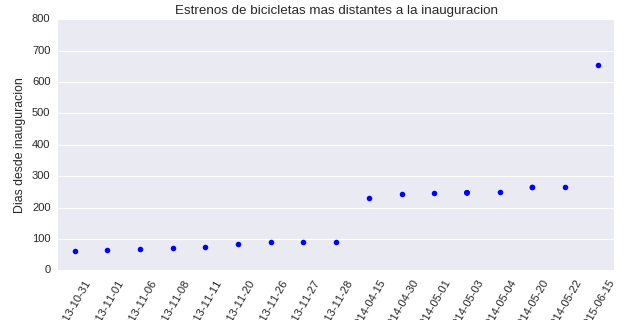

In [65]:
plotDf = firstLastByBikeDf.sort_values(by='days_to_first', ascending=False).head(20)
plotDf['day'] = plotDf['first_trip'].map(lambda x: x.date())
plotDf.sort_values(by='day', inplace=True)
plotDf.rename(columns={'day':'Dia de estreno', 'days_to_first':'Dias desde inauguracion'}, inplace=True)
g = sns.factorplot(x='Dia de estreno', y='Dias desde inauguracion', data=plotDf, kind = 'strip', size=4, aspect = 2, color='blue')
g.axes.flat[0].set_title('Estrenos de bicicletas mas distantes a la inauguracion')
g.axes.flat[0].set(ylim=(0, 800))
g.set_xticklabels(rotation=60)

Vemos que encontramos bicicletas que se estrenaron pasados muchos días desde la inauguración del servicio. En particular, hay una bicicleta que se estrenó a más de 600 días de la inauguración:

In [66]:
firstLastByBikeDf.sort_values(by='first_trip').tail(1)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
696,740,2015-06-15 08:25:00,2015-06-29 06:24:00,655 days,655,63 days,63


Estos datos llevan a pensar sobre si fueron agregadas bicicletas luego de la inauguración. Se buscaron noticias en internet sobre ese evento, las cuales informaban cuántas bicicletas habría: algunas decían 600, otras 700. Si fueran 600, se explicaría que otras 100 se fueran agregando paulatinamente y dieran como resultado estos datos. Si desde el inicio hubo 700, quiere decir que hubo al menos una bicicleta que tardó más de un año y medio en estrenarse.

Ahora, veamos las bicicletas que hace más tiempo no se usan, posicionandonos en el último día del que se tiene registros:

In [67]:
firstLastByBikeDf.sort_values(by='time_since_last', ascending=False).head(5)

,bike_id,first_trip,last_trip,time_to_first,days_to_first,time_since_last,days_since_last
454,476,2013-08-29 11:15:00,2013-09-07 17:37:00,0 days,0,723 days,723
438,460,2013-08-29 13:43:00,2013-09-07 13:55:00,0 days,0,723 days,723
302,323,2013-08-30 08:59:00,2013-09-07 18:13:00,1 days,1,723 days,723
543,565,2013-08-29 13:45:00,2013-09-07 14:35:00,0 days,0,723 days,723
295,316,2013-08-29 09:24:00,2013-09-07 23:03:00,0 days,0,723 days,723


<IPython.core.display.Javascript object>


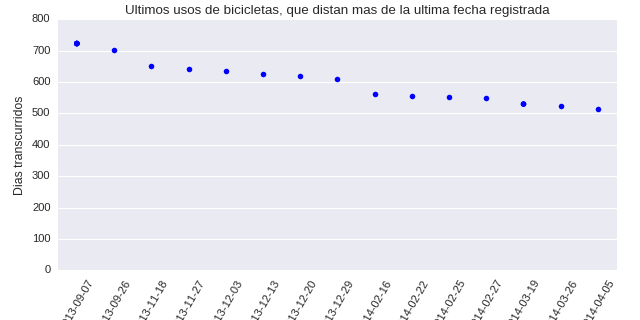

In [68]:
plotDf = firstLastByBikeDf.sort_values(by='days_since_last', ascending=False).head(20)
plotDf['day'] = plotDf['last_trip'].map(lambda x: x.date())
plotDf.sort_values(by='day', inplace=True)
plotDf.rename(columns={'day':'Dia de ultimo uso', 'days_since_last':'Dias transcurridos'}, inplace=True)
g = sns.factorplot(x='Dia de ultimo uso', y='Dias transcurridos', data=plotDf, kind = 'strip', size=4, aspect = 2, color='blue')
g.axes.flat[0].set_title('Ultimos usos de bicicletas, que distan mas de la ultima fecha registrada')
g.axes.flat[0].set(ylim=(0, 800))
g.set_xticklabels(rotation=60)

Nos encontramos con bicicletas que no se utilizan hace más de 500 días. Esto podría explicarse si no se repusieran las bicicletas robadas o que ya no puedan utilizarse. Veamos la cantidad de bicicletas en esta situación.

Analizamos la cantidad de bicicletas inactivas considerando distintos rangos de inactividad:

In [69]:
#Rango desde 1 día a 723 (máximo de días de inactividad analizados), con intervalos de 30 días.
daysRange = range(1, 723, 30)
inactiveBikes = []
for i in daysRange:
    inactiveCount = len(firstLastByBikeDf[firstLastByBikeDf['days_since_last'] > i])
    inactiveBikes.append(inactiveCount)

    
inactiveBikesDf = pd.DataFrame(data={'Periodo':pd.Series(data=list(daysRange)), 'Bicicletas inactivas':pd.Series(data=inactiveBikes)})
inactiveBikesDf.head(10)


,Bicicletas inactivas,Periodo
0,292,1
1,105,31
2,82,61
3,71,91
4,66,121
5,61,151
6,52,181
7,48,211
8,46,241
9,41,271


<IPython.core.display.Javascript object>


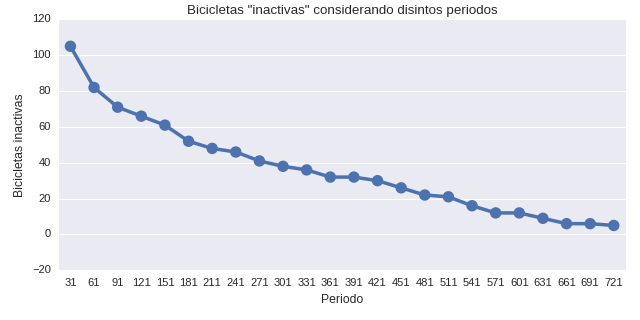

In [70]:
g = sns.factorplot(x='Periodo', y='Bicicletas inactivas', data=inactiveBikesDf[inactiveBikesDf['Periodo'] > 30], size=4, aspect = 2)
g.axes.flat[0].set_title('Bicicletas "inactivas" considerando disintos periodos')

Vemos que la cantidad de bicicletas inactivas parece bastante alto. Por ejemplo, hay 105 bicicletas que no se utilizan desde hace un 31 días. Pongámoslo en porcentajes:

In [71]:
inactiveBikesDf['Porcentaje de inactivas'] = inactiveBikesDf['Bicicletas inactivas'].map(lambda x: (x*100)/700)

In [72]:
inactiveBikesDf.head(5)

,Bicicletas inactivas,Periodo,Porcentaje de inactivas
0,292,1,41
1,105,31,15
2,82,61,11
3,71,91,10
4,66,121,9


<IPython.core.display.Javascript object>


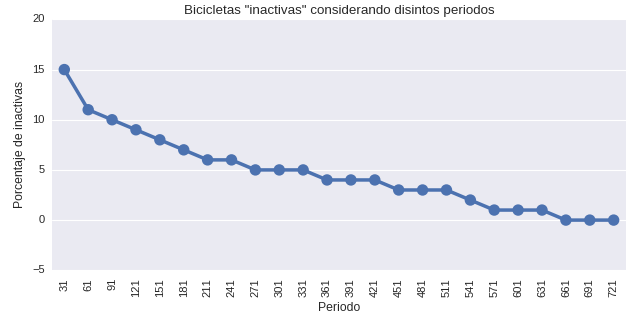

In [73]:
g = sns.factorplot(x='Periodo', y='Porcentaje de inactivas', data=inactiveBikesDf[inactiveBikesDf['Periodo'] > 30], size=4, aspect = 2)
g.axes.flat[0].set_title('Bicicletas "inactivas" considerando disintos periodos')
g.set_xticklabels(rotation=90)

Por ejemplo, en los últimos 31 días no se utilizó al 15% de las bicicletas.

Veamos en la última semana:

In [74]:
#Total de bicicletas sin usar en la última semana
len(firstLastByBikeDf[firstLastByBikeDf['days_since_last'] > 7])

185

In [75]:
#Porcentaje de bicicletas sin usar en la última semana
(len(firstLastByBikeDf[firstLastByBikeDf['days_since_last'] > 7])*100)/700

26

En la última semana, el 26% de las bicicletas NO fue utilizado.

### ¿Cuál es el tiempo inactividad promedio hasta la última fecha dada?  

In [76]:
firstLastByBikeDf['time_since_last'].mean()

Timedelta('42 days 03:05:08.571428')

Vemos una inactividad promedio de 42 días por bicicleta, desde el último uso a la actualidad.

# Conclusiones:

Analizamos el comportamiento de los clientes del servicio público de bicicletas de la ciudad de San Francisco, determinado datos como:

- La mayor demanda se produce en los días laborales.
- La temperatura que más favorece al uso es entre 12ºC y 21ºC.
- Se utiliza normalmente el servicio hasta con vientos de 10 mph (16km/h).
- La visibilidad en San Francisco se mantiene en torno a las 10 millas (1,6km).


- La mayor cantidad de viajes se originan en San Francisco.
- Hay una considerable cantidad de viajes entre distintas ciudades.


- El uso de las bicicletas va en aumento: alrededor del 11% anual.
- Existe una tendencia general a que las estaciones se queden cada vez más sin bicicletas. 
- Los registros en que las estaciones no tienen bicicletas sin más comunes a la mañana (pico a las 9hs) y a la tarde (pico a las 18hs).
- Las bicicletas tienen un tiempo considerable de inactividad: 42 días desde el último uso a la actualidad, en promedio.

Sobre estos últimos puntos, consideramos que podría plantearse algún mecanismo para reducir el tiempo de inactividad de las bicicletas, lo que favorecería a mayor oferta de las estaciones para satisfacer la demanda creciente del servicio.